In [1]:
library(igraph)
library(utils)
library(ggplot2)
library(foreach)
library(data.table)
library(dplyr)
library(doParallel)
library(RPostgreSQL)
library(itertools)
library(RColorBrewer)


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union


Attaching package: ‘dplyr’

The following objects are masked from ‘package:data.table’:

    between, first, last

The following objects are masked from ‘package:igraph’:

    as_data_frame, groups, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: iterators
Loading required package: parallel
Loading required package: DBI


In [2]:
set.seed(27042012)

In [3]:
drv = dbDriver("PostgreSQL")
con = dbConnect(drv, dbname = "yourdb")

In [5]:
analysis='number_buds_per_filament'
comparison='normal_vs_high'
filepre=paste("FDGENEA",analysis,comparison,sep=".")

In [6]:
n=read.delim("../GENIE3.top10_target_ranks.communities_PLM.with_node_centralities.csv",sep=";",stringsAsFactors=FALSE)
n=as.data.table(n)
n=setkey(n,"geneid")

In [7]:
a=as.data.table(read.delim("../GENIE3.top10_target_ranks.ranked_regulator_target_interactions.with_communities.correlations_and_directionality.tsv.gz",sep="\t",stringsAsFactors=FALSE))
a=setkeyv(a,c("regulatoryGene","targetGene"))
nrow(a)
a=a[!regulatoryGene==targetGene]
nrow(a)

[1] 356457

[1] 356390

In [8]:
n$is_regulator=n$geneid %in% unique(a$regulatoryGene)
nrow(n)
n=n[geneid %in% union(a$regulatoryGene,a$targetGene)]
nrow(n)

[1] 35706

[1] 35639

In [9]:
sql="select geneid,name as gene_name, reg_class,superfamily, description from physcogrn.gene_name "
N=dbGetQuery(con,sql)
nrow(N)
N$gene_name=gsub("Phypa_\\d+,?","",N$gene_name,perl=TRUE,ignore.case =TRUE)
N$gene_name[N$gene_name ==""]=NA
head(N)
n=merge(n,N,by="geneid",all.x=TRUE)
nrow(n)
head(n)

[1] 35706

geneid,gene_name,reg_class,superfamily,description
Pp3c10_10040.mRNA,NA,NA,NA,PTHR36351:SF1 - EMBRYO SAC DEVELOPMENT ARREST 12 PROTEIN (1 of 2)
Pp3c10_10090.mRNA,NA,NA,NA,NA
Pp3c10_10095.C_D_box_snoRNA,NA,NA,NA,NA
Pp3c10_100.ncRNA,NA,NA,NA,NA
Pp3c10_10100.mRNA,NA,NA,NA,NA
Pp3c10_10130.mRNA,NA,NA,NA,NA


[1] 35639

geneid,community,degree_centrality,betweenness_centrality,eigenvector_centrality,local_reaching_centrality,centrality_rank,is_regulator,gene_name,reg_class,superfamily,description
Pp3c10_100.ncRNA,VII,0,0,3.157888e-03,0,2754,FALSE,NA,NA,NA,NA
Pp3c10_10040.mRNA,VIII,0,0,6.931960e-03,0,2152,FALSE,NA,NA,NA,PTHR36351:SF1 - EMBRYO SAC DEVELOPMENT ARREST 12 PROTEIN (1 of 2)
Pp3c10_10090.mRNA,II,0,0,7.304196e-05,0,4184,FALSE,NA,NA,NA,NA
Pp3c10_10095.C_D_box_snoRNA,VI,0,0,4.084910e-03,0,1472,FALSE,NA,NA,NA,NA
Pp3c10_10100.mRNA,IV,0,0,0.000000e+00,0,2516,FALSE,NA,NA,NA,NA
Pp3c10_10130.mRNA,V,0,0,4.468795e-03,0,2450,FALSE,NA,NA,NA,NA


In [10]:
col=read.csv("../subnetwork_colours.csv",stringsAsFactors=FALSE)
col
n$color=col[match(n$community,col$network),"colour"]
head(n)

network,colour
I,#999999
II,#FFE529
III,#5A6A99
IV,#FF7F00
V,#E486B7
VI,#6B886E
VII,#E41A1C
VIII,#CA9A2C
IX,#AD5882
X,#C66764


geneid,community,degree_centrality,betweenness_centrality,eigenvector_centrality,local_reaching_centrality,centrality_rank,is_regulator,gene_name,reg_class,superfamily,description,color
Pp3c10_100.ncRNA,VII,0,0,3.157888e-03,0,2754,FALSE,NA,NA,NA,NA,#E41A1C
Pp3c10_10040.mRNA,VIII,0,0,6.931960e-03,0,2152,FALSE,NA,NA,NA,PTHR36351:SF1 - EMBRYO SAC DEVELOPMENT ARREST 12 PROTEIN (1 of 2),#CA9A2C
Pp3c10_10090.mRNA,II,0,0,7.304196e-05,0,4184,FALSE,NA,NA,NA,NA,#FFE529
Pp3c10_10095.C_D_box_snoRNA,VI,0,0,4.084910e-03,0,1472,FALSE,NA,NA,NA,NA,#6B886E
Pp3c10_10100.mRNA,IV,0,0,0.000000e+00,0,2516,FALSE,NA,NA,NA,NA,#FF7F00
Pp3c10_10130.mRNA,V,0,0,4.468795e-03,0,2450,FALSE,NA,NA,NA,NA,#E486B7


In [11]:
sql=sprintf("select * from physcogrn.dek1dge_full where analysis='%s' and comparison='%s'",analysis,comparison)
print(sql)
P=dbGetQuery(con,sql)
nrow(P)
head(P)

[1] "select * from physcogrn.dek1dge_full where analysis='number_buds_per_filament' and comparison='normal_vs_high'"


[1] 21953

analysis,comparison,geneid,test_stat,pval_lrt,qval_lrt,rss,sigma_sq_lrt,mean_obs_lrt,var_obs_lrt,⋯,degrees_free,pval_wt,qval_wt,b,se_b,mean_obs_wt,var_obs_wt,sigma_sq_wt,smooth_sigma_sq_wt,direction
number_buds_per_filament,normal_vs_high,Pp3c24_5330.mRNA,48.11211,4.025330e-12,5.029556e-08,14.848392,0.5419830,5.140348,0.5152907,⋯,1,2.202312e-24,4.834736e-20,-1.2842458,0.12603256,5.140348,0.5152907,0.10640882,0.06370882,down
number_buds_per_filament,normal_vs_high,Pp3c1_8740.mRNA,46.84773,7.672192e-12,5.029556e-08,19.897292,0.7144186,4.204884,0.7567372,⋯,1,1.047298e-22,6.907542e-19,-1.4794231,0.15084912,4.204884,0.7567372,0.13666276,0.14132116,down
number_buds_per_filament,normal_vs_high,Pp3c3_13600.mRNA,46.46252,9.338755e-12,5.029556e-08,265.373241,9.7425259,2.982453,9.1796218,⋯,1,7.344867e-23,6.907542e-19,-5.3906541,0.54766087,2.982453,9.1796218,2.07340082,0.27383048,down
number_buds_per_filament,normal_vs_high,Pp3c11_5700.mRNA,46.20107,1.067189e-11,5.029556e-08,3.269426,0.1190376,6.364174,0.1179318,⋯,1,1.258606e-22,6.907542e-19,-0.5976377,0.06105362,6.364174,0.1179318,0.02478607,0.02433135,down
number_buds_per_filament,normal_vs_high,Pp3c11_2480.mRNA,46.06228,1.145528e-11,5.029556e-08,119.503942,4.2868272,2.008608,4.1494439,⋯,1,1.671994e-22,7.341057e-19,3.6109373,0.36997410,2.008608,4.1494439,0.84629729,0.38073369,up
number_buds_per_filament,normal_vs_high,Pp3c11_7600.mRNA,43.81900,3.601907e-11,1.132167e-07,69.815944,2.5498194,4.871604,2.4078890,⋯,1,1.382841e-20,4.373339e-17,2.7305796,0.29355866,4.871604,2.4078890,0.58451585,0.08368615,up


In [12]:
p=subset(P,qval_lrt<0.1)
nrow(p)

[1] 3725

In [13]:
head(P[,c("geneid","test_stat","b","qval_lrt","direction")])

geneid,test_stat,b,qval_lrt,direction
Pp3c24_5330.mRNA,48.11211,-1.2842458,5.029556e-08,down
Pp3c1_8740.mRNA,46.84773,-1.4794231,5.029556e-08,down
Pp3c3_13600.mRNA,46.46252,-5.3906541,5.029556e-08,down
Pp3c11_5700.mRNA,46.20107,-0.5976377,5.029556e-08,down
Pp3c11_2480.mRNA,46.06228,3.6109373,5.029556e-08,up
Pp3c11_7600.mRNA,43.81900,2.7305796,1.132167e-07,up


In [14]:
P$direction[P$qval_lrt>=0.1]="unchanged"
table(P$direction)


     down unchanged        up 
     1736     18228      1989 

In [15]:
min(P$test_stat)

[1] -0.1322098

In [16]:
n=merge(n,P[,c("geneid","test_stat","b","qval_lrt","direction")],all.x=TRUE)
n[is.na(n$test_stat),test_stat:=-1]
n[is.na(n$b),b:=0]
n[is.na(n$qval_lrt),qval_lrt:=1]
n[is.na(n$direction),direction:="unchanged"]
nrow(na.omit(n))
nrow(n)

[1] 1393

[1] 35639

In [17]:
head(n)

geneid,community,degree_centrality,betweenness_centrality,eigenvector_centrality,local_reaching_centrality,centrality_rank,is_regulator,gene_name,reg_class,superfamily,description,color,test_stat,b,qval_lrt,direction
Pp3c10_100.ncRNA,VII,0,0,3.157888e-03,0,2754,FALSE,NA,NA,NA,NA,#E41A1C,-1.0000000,0.0000000,1.000000000,unchanged
Pp3c10_10040.mRNA,VIII,0,0,6.931960e-03,0,2152,FALSE,NA,NA,NA,PTHR36351:SF1 - EMBRYO SAC DEVELOPMENT ARREST 12 PROTEIN (1 of 2),#CA9A2C,6.1922788,0.2185157,0.084309021,up
Pp3c10_10090.mRNA,II,0,0,7.304196e-05,0,4184,FALSE,NA,NA,NA,NA,#FFE529,-1.0000000,0.0000000,1.000000000,unchanged
Pp3c10_10095.C_D_box_snoRNA,VI,0,0,4.084910e-03,0,1472,FALSE,NA,NA,NA,NA,#6B886E,2.5046369,0.1916762,0.259210620,unchanged
Pp3c10_10100.mRNA,IV,0,0,0.000000e+00,0,2516,FALSE,NA,NA,NA,NA,#FF7F00,12.5937376,-0.2262322,0.008234586,down
Pp3c10_10130.mRNA,V,0,0,4.468795e-03,0,2450,FALSE,NA,NA,NA,NA,#E486B7,0.6021746,-0.1126142,0.524615971,unchanged


In [18]:
a=merge(merge(a,P[,c("geneid","b")],by.x="targetGene",by.y="geneid", all.x=TRUE),P[,c("geneid","b")], by.x="regulatoryGene",by.y="geneid", all.x=TRUE,suffixes=c("_tar","_reg"))
nrow(a)
a[is.na(b_tar),b_tar:=0]
a[is.na(b_reg),b_reg:=0]
nrow(na.omit(a))
nrow(a)
head(a)

[1] 356390

[1] 356390

[1] 356390

regulatoryGene,targetGene,full_cor,full_reg,our_cor,our_reg,weight,regulator_rank,target_rank,mutual_rank,regulator_community,target_community,community,b_tar,b_reg
Pp3c10_10240.mRNA,Pp3c10_11390.mRNA,0.1629686,+,0.02831237,+,0.005660583,497,10,70.49823,V,IX,0,-0.03070880,-0.05007167
Pp3c10_10240.mRNA,Pp3c10_15180.mRNA,-0.6447082,-,-0.71211682,-,0.013129053,54,5,16.43168,V,VIII,0,-0.02955047,-0.05007167
Pp3c10_10240.mRNA,Pp3c10_22090.mRNA,0.2743636,+,0.25104004,+,0.006067703,444,7,55.74944,V,VII,0,0.00000000,-0.05007167
Pp3c10_10240.mRNA,Pp3c10_2500.mRNA,0.1254628,+,-0.61095287,-,0.005851491,470,8,61.31884,V,VIII,0,-0.02207314,-0.05007167
Pp3c10_10240.mRNA,Pp3c10_25280.mRNA,-0.3250879,-,-0.10272077,-,0.005310891,554,9,70.61161,V,VII,0,0.00000000,-0.05007167
Pp3c10_10240.mRNA,Pp3c11_10340.ncRNA,-0.5006557,-,-0.27303917,-,0.009111356,179,10,42.30839,V,VI,0,0.00000000,-0.05007167


In [19]:
a=a[a$regulatoryGene %in% n$geneid & a$targetGene %in% n$geneid,] # all links 
A=a[community %in% as.character(as.roman(1:11))] #only intra-subnetwork links
ATF=A[regulatoryGene %in% n[reg_class=="TF"][["geneid"]]] #only TF intra
aTF=a[regulatoryGene %in% n[reg_class=="TF"][["geneid"]]] #only TF all
nrow(a)
nrow(A)
nrow(ATF)
nrow(aTF)
head(a)

[1] 356390

[1] 215035

[1] 126791

[1] 215407

regulatoryGene,targetGene,full_cor,full_reg,our_cor,our_reg,weight,regulator_rank,target_rank,mutual_rank,regulator_community,target_community,community,b_tar,b_reg
Pp3c10_10240.mRNA,Pp3c10_11390.mRNA,0.1629686,+,0.02831237,+,0.005660583,497,10,70.49823,V,IX,0,-0.03070880,-0.05007167
Pp3c10_10240.mRNA,Pp3c10_15180.mRNA,-0.6447082,-,-0.71211682,-,0.013129053,54,5,16.43168,V,VIII,0,-0.02955047,-0.05007167
Pp3c10_10240.mRNA,Pp3c10_22090.mRNA,0.2743636,+,0.25104004,+,0.006067703,444,7,55.74944,V,VII,0,0.00000000,-0.05007167
Pp3c10_10240.mRNA,Pp3c10_2500.mRNA,0.1254628,+,-0.61095287,-,0.005851491,470,8,61.31884,V,VIII,0,-0.02207314,-0.05007167
Pp3c10_10240.mRNA,Pp3c10_25280.mRNA,-0.3250879,-,-0.10272077,-,0.005310891,554,9,70.61161,V,VII,0,0.00000000,-0.05007167
Pp3c10_10240.mRNA,Pp3c11_10340.ncRNA,-0.5006557,-,-0.27303917,-,0.009111356,179,10,42.30839,V,VI,0,0.00000000,-0.05007167


In [20]:
g=graph_from_data_frame(a,directed = TRUE,vertices = n)
G=graph_from_data_frame(A,directed = TRUE,vertices = n)
gTF=graph_from_data_frame(aTF,directed = TRUE,vertices = n)
GTF=graph_from_data_frame(ATF,directed = TRUE,vertices = n)
is_weighted(G)
list.edge.attributes(G)
list.vertex.attributes(G)

[1] TRUE

[1] "full_cor"            "full_reg"            "our_cor"            
 [4] "our_reg"             "weight"              "regulator_rank"     
 [7] "target_rank"         "mutual_rank"         "regulator_community"
[10] "target_community"    "community"           "b_tar"              
[13] "b_reg"

[1] "name"                      "community"                
 [3] "degree_centrality"         "betweenness_centrality"   
 [5] "eigenvector_centrality"    "local_reaching_centrality"
 [7] "centrality_rank"           "is_regulator"             
 [9] "gene_name"                 "reg_class"                
[11] "superfamily"               "description"              
[13] "color"                     "test_stat"                
[15] "b"                         "qval_lrt"                 
[17] "direction"

In [21]:
#extending nodes to include the two clostest regulators (irrespective of whether they're sig. associated with the trait)
nrow(p)
extend=na.omit(unique(unlist(lapply(seq_len(nrow(p)), function(i) {subcomponent(g,p[i,"geneid"],mode="in")$name[1:3]}))))#get genes themselves and the two closests TFs
fil=unlist(lapply(extend,function(x) {
    x %in% p[,"geneid"] | length(intersect(p[,"geneid"],subcomponent(g,x,mode="out")$name[1:11]))>1 #testing how many unassociated upstream
}))
table(fil)
length(extend)
extend=extend[fil]
length(extend)
head(extend)

[1] 3725

fil
FALSE  TRUE 
  368  3808 

[1] 4176

[1] 3808

[1] "Pp3c24_5330.mRNA"  "Pp3c10_22600.mRNA" "Pp3c12_13280.mRNA"
[4] "Pp3c1_8740.mRNA"   "Pp3c12_13250.mRNA" "Pp3c13_10800.mRNA"

In [22]:
subG=induced_subgraph(g, extend) #get the induced subgraph for the extended set

In [23]:
#analyze network structure and cumulative association with the trait of induced subgraph
cl=parallel::makeCluster(50, type="PSOCK")
doParallel::registerDoParallel(cl)
extendo=foreach(i=seq_along(extend),.combine="rbind.data.frame",.options.rsr=list(chunkSize=200),.packages=c("igraph"))  %dopar%  {
    downstream=subcomponent(subG,extend[i],mode="out")$name
    direct=adjacent_vertices(subG, extend[i], mode = "out")[[1]]$name
    downstreamab=sum(abs(p[p$geneid %in% downstream, "b"]))
    downstreamb=sum(p[p$geneid %in% downstream, "b"])
    directab=sum(abs(p[p$geneid %in% direct, "b"]))
    directb=sum(p[p$geneid %in% direct, "b"])
    return(data.frame(
        geneid=extend[i],
        associated=extend[i] %in% p[,"geneid"],
        downstream=length(downstream)-1,
        downstream_reg=nrow(N[N$geneid %in% downstream & !is.na(N$reg_class), ]),
        downstream_TF=nrow(N[N$geneid %in% downstream & !is.na(N$reg_class) & N$reg_class=="TF", ]),
        downstream_cab=downstreamab,
        downstream_cb=downstreamb,
        direct=length(direct),
        direct_reg=nrow(N[N$geneid %in% direct & !is.na(N$reg_class), ]),
        direct_TF=nrow(N[N$geneid %in% direct & !is.na(N$reg_class) & N$reg_class=="TF", ]),
        direct_cab=directab,
        direct_cb=directb
    ))
}
stopCluster(cl)

In [24]:
nrow(extendo)
length(extend)
head(extendo)

[1] 3808

[1] 3808

geneid,associated,downstream,downstream_reg,downstream_TF,downstream_cab,downstream_cb,direct,direct_reg,direct_TF,direct_cab,direct_cb
Pp3c24_5330.mRNA,TRUE,0,0,0,1.284246,-1.284246,0,0,0,0.00000,0.000000
Pp3c10_22600.mRNA,TRUE,3285,292,208,1797.561961,436.301449,44,6,4,26.42961,-16.696388
Pp3c12_13280.mRNA,TRUE,3285,292,208,1797.561961,436.301449,217,23,12,82.69164,-55.591193
Pp3c1_8740.mRNA,TRUE,0,0,0,1.479423,-1.479423,0,0,0,0.00000,0.000000
Pp3c12_13250.mRNA,FALSE,3285,292,208,1797.561961,436.301449,87,5,5,32.69656,-21.898480
Pp3c13_10800.mRNA,FALSE,3285,292,208,1797.561961,436.301449,37,7,7,20.20343,-5.560412


In [25]:
extendo$geneid=as.character(extendo$geneid)
str(extendo)

'data.frame':	3808 obs. of  12 variables:
 $ geneid        : chr  "Pp3c24_5330.mRNA" "Pp3c10_22600.mRNA" "Pp3c12_13280.mRNA" "Pp3c1_8740.mRNA" ...
 $ associated    : logi  TRUE TRUE TRUE TRUE FALSE FALSE ...
 $ downstream    : num  0 3285 3285 0 3285 ...
 $ downstream_reg: int  0 292 292 0 292 292 0 1 0 292 ...
 $ downstream_TF : int  0 208 208 0 208 208 0 1 0 208 ...
 $ downstream_cab: num  1.28 1797.56 1797.56 1.48 1797.56 ...
 $ downstream_cb : num  -1.28 436.3 436.3 -1.48 436.3 ...
 $ direct        : int  0 44 217 0 87 37 0 29 0 52 ...
 $ direct_reg    : int  0 6 23 0 5 7 0 0 0 6 ...
 $ direct_TF     : int  0 4 12 0 5 7 0 0 0 6 ...
 $ direct_cab    : num  0 26.4 82.7 0 32.7 ...
 $ direct_cb     : num  0 -16.7 -55.6 0 -21.9 ...


In [26]:
extendo=merge(extendo,n,by="geneid")
nrow(extendo)
head(extendo)

[1] 3808

geneid,associated,downstream,downstream_reg,downstream_TF,downstream_cab,downstream_cb,direct,direct_reg,direct_TF,⋯,is_regulator,gene_name,reg_class,superfamily,description,color,test_stat,b,qval_lrt,direction
Pp3c1_10400.mRNA,TRUE,0,0,0,0.1977090,0.1977090,0,0,0,⋯,FALSE,NA,NA,NA,"PTHR11731//PTHR11731:SF126 - PROTEASE FAMILY S9B,C DIPEPTIDYL-PEPTIDASE IV-RELATED // SUBFAMILY NOT NAMED (1 of 1)",#449B76,11.80757,0.1977090,0.0109561212,up
Pp3c1_1080.mRNA,TRUE,0,0,0,0.7328859,-0.7328859,0,0,0,⋯,FALSE,NA,NA,NA,NA,#E41A1C,9.55567,-0.7328859,0.0249199997,down
Pp3c1_10970.mRNA,TRUE,0,0,0,0.4193551,-0.4193551,0,0,0,⋯,FALSE,NA,NA,NA,PF08263 - Leucine rich repeat N-terminal domain (LRRNT_2) (1 of 120),#E486B7,19.45862,-0.4193551,0.0006677017,down
Pp3c1_11030.mRNA,TRUE,0,0,0,0.6112699,-0.6112699,0,0,0,⋯,FALSE,NA,NA,NA,2.7.11.18 - [Myosin light-chain] kinase / Smooth-muscle-myosin-light-chain kinase (1 of 3),#E486B7,10.36913,-0.6112699,0.0185069608,down
Pp3c1_11690.mRNA,TRUE,0,0,0,0.5351013,-0.5351013,0,0,0,⋯,FALSE,NA,NA,NA,"K09832 - cytochrome P450, family 710, subfamily A (CYP710A) (1 of 2)",#FFE529,14.49643,-0.5351013,0.0041885256,down
Pp3c1_11980.mRNA,TRUE,0,0,0,0.3523362,-0.3523362,0,0,0,⋯,FALSE,NA,NA,NA,PF06886 - Targeting protein for Xklp2 (TPX2) (TPX2) (1 of 18),#E486B7,13.82813,-0.3523362,0.0052538964,down


In [27]:
table(extendo$community,extendo$reg_class)

      
       miRNA PT TF TR
  I        0  2 20  2
  II       0  9 63  9
  III      0  0  7  2
  IV       1  0 10  2
  IX       0  3 22 17
  V        0  8 29 19
  VI       1  0  9  2
  VII      0  0 13  6
  VIII     0  2 12  3
  X        0  5 22  1
  XI       0  0 23  6

In [28]:
options(repr.plot.width=15, repr.plot.height=15)

Warning message in text.default(x, y, labels = labels, col = label.color, family = label.family, :
“conversion failure on 'MS2‐1' in 'mbcsToSbcs': dot substituted for <e2>”Warning message in text.default(x, y, labels = labels, col = label.color, family = label.family, :
“conversion failure on 'MS2‐1' in 'mbcsToSbcs': dot substituted for <80>”Warning message in text.default(x, y, labels = labels, col = label.color, family = label.family, :
“conversion failure on 'MS2‐1' in 'mbcsToSbcs': dot substituted for <90>”Warning message in text.default(x, y, labels = labels, col = label.color, family = label.family, :
“font metrics unknown for Unicode character U+2010”Warning message in text.default(x, y, labels = labels, col = label.color, family = label.family, :
“conversion failure on 'MS2‐1' in 'mbcsToSbcs': dot substituted for <e2>”Warning message in text.default(x, y, labels = labels, col = label.color, family = label.family, :
“conversion failure on 'MS2‐1' in 'mbcsToSbcs': dot substituted

png 
  2

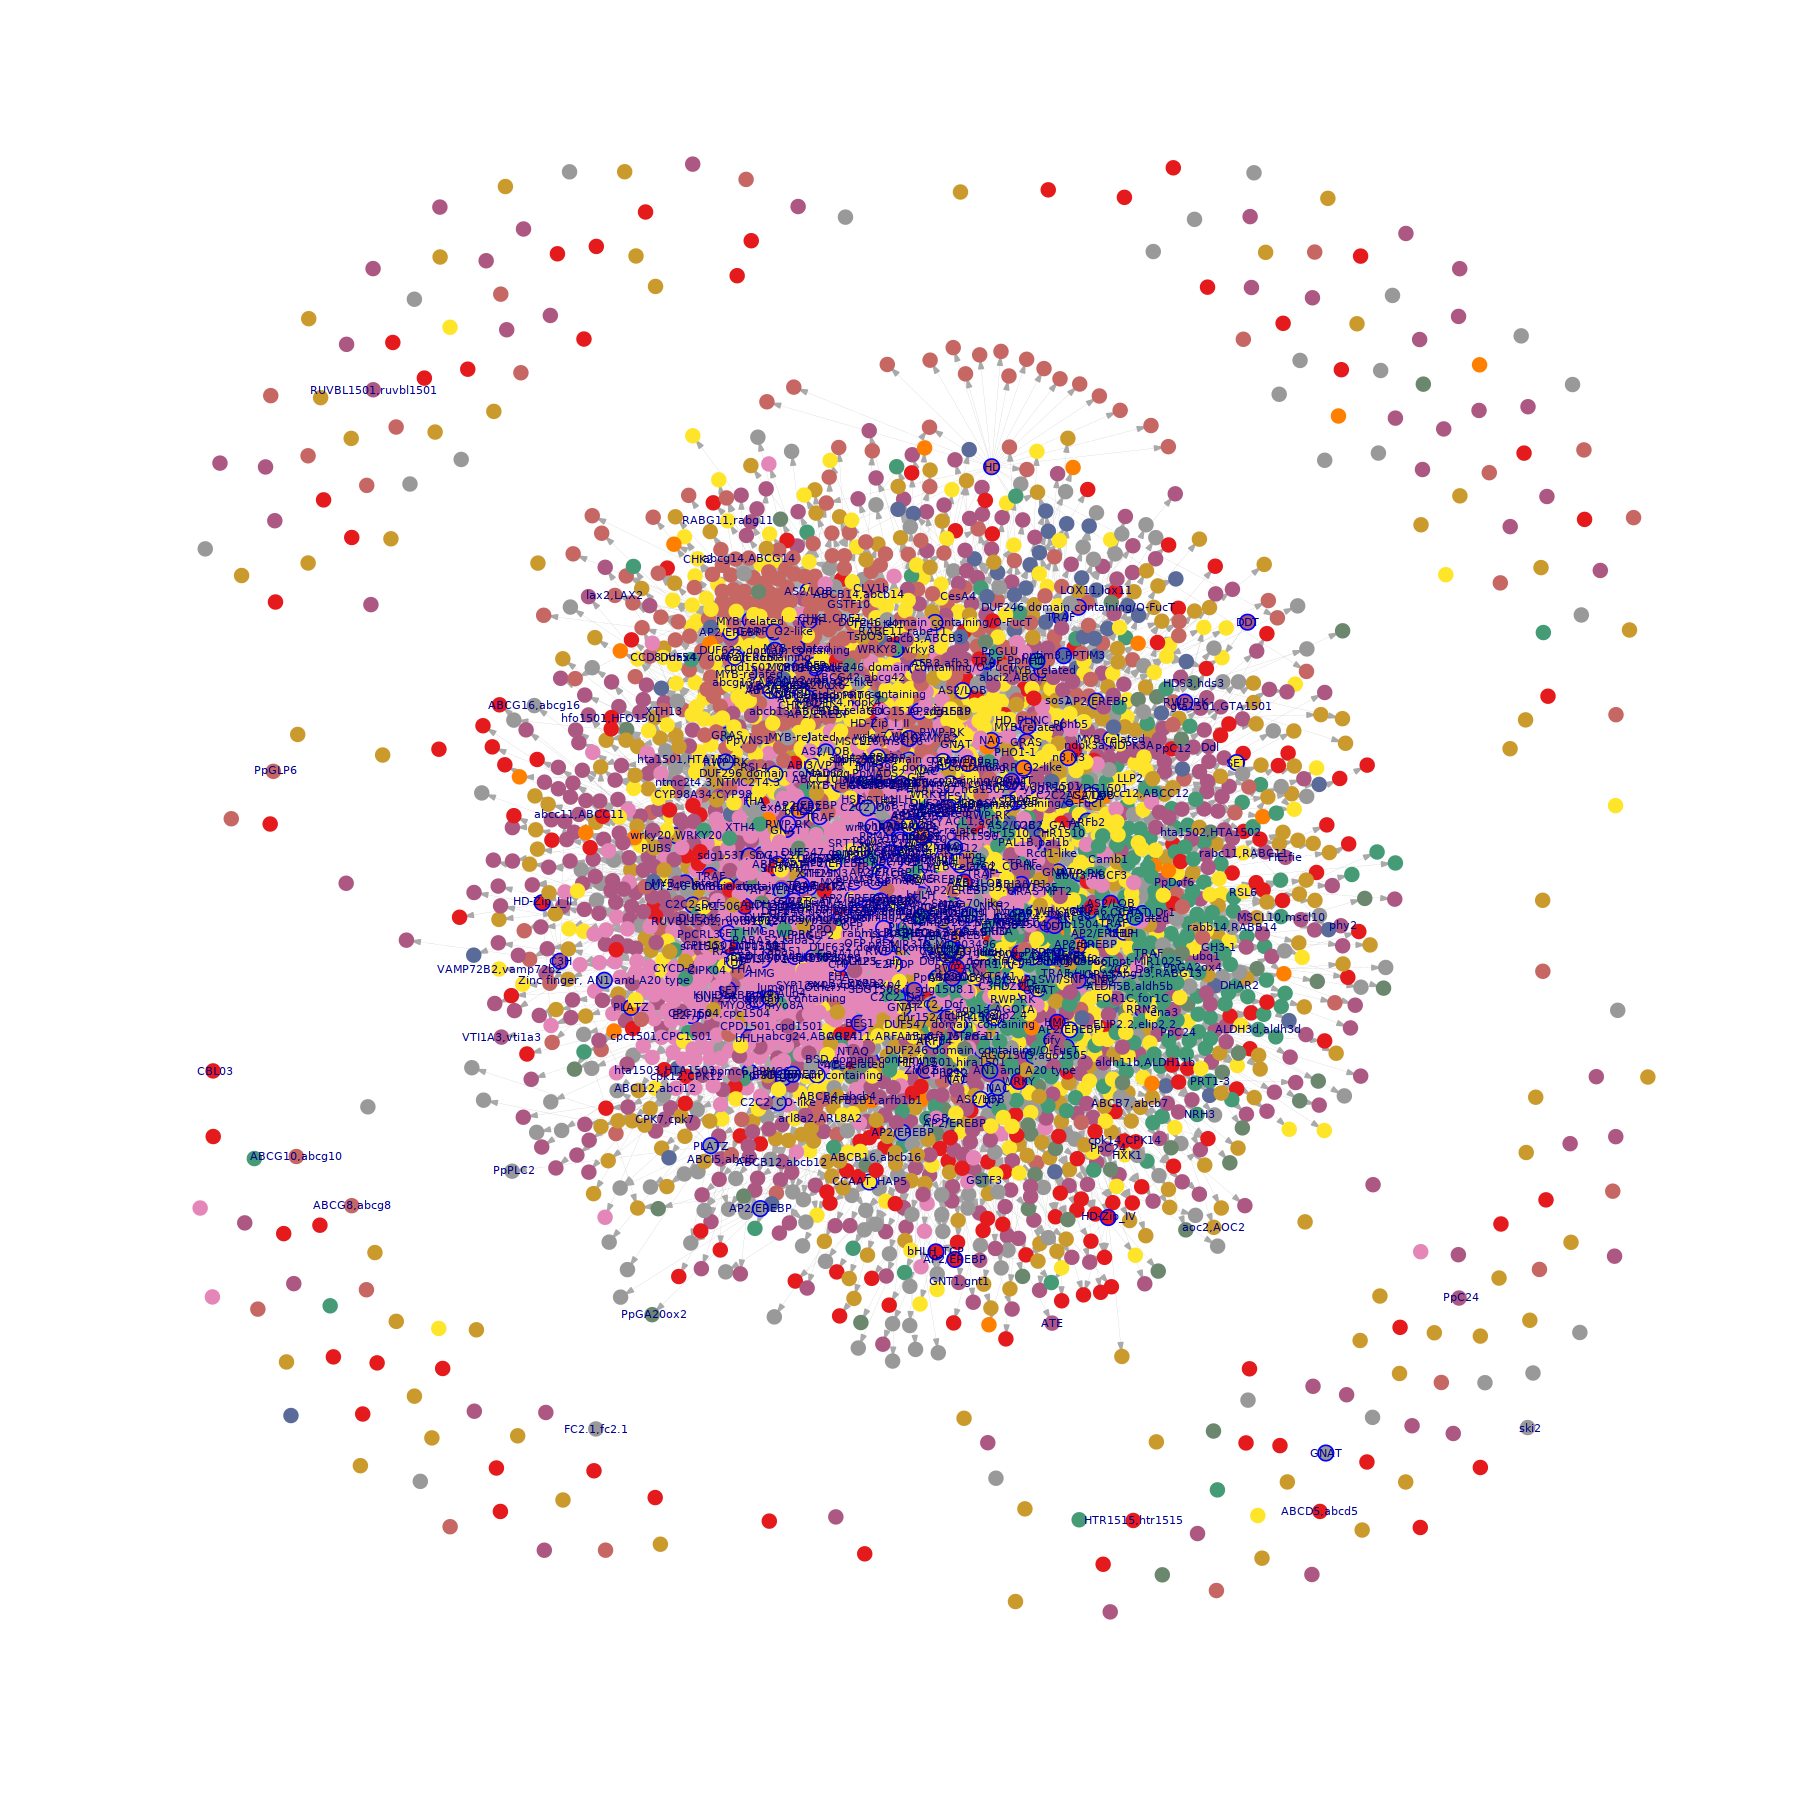

In [29]:
col2=rep(NA,length(V(subG)))
col2[V(subG)$is_regulator]="blue"
col2[V(subG)$is_TF]="black"
set.seed(27042012)
lay=layout_with_graphopt(subG)
pdf(paste(filepre,"full.pdf",sep="."),width=15,height=15)
plot(subG,layout=lay,vertex.size=2,vertex.frame.color=col2,vertex.label=V(subG)$gene_name,vertex.label.cex=0.5,vertex.color=V(subG)$color,edge.width=0.1,edge.arrow.size=0.1)
dev.off()
plot(subG,layout=lay,vertex.size=2,vertex.frame.color=col2,vertex.label=V(subG)$gene_name,vertex.label.cex=0.5,vertex.color=V(subG)$color,edge.width=0.1,edge.arrow.size=0.1)

In [30]:
clu=components(subG)

In [31]:
GR=as.data.frame(clu$membership)
GR=data.frame(geneid=as.character(row.names(GR)),GR)
row.names(GR)=NULL
names(GR)[2]="comp"
head(GR)

geneid,comp
Pp3c10_10040.mRNA,1
Pp3c10_10100.mRNA,1
Pp3c10_10460.mRNA,1
Pp3c10_1100.mRNA,1
Pp3c10_11020.mRNA,1
Pp3c10_11042.mRNA,1


In [32]:
nrow(GR)
GR=GR[GR$comp %in% which(table(GR$comp)>1),]
nrow(GR)

[1] 3808

[1] 3572

In [33]:
GR$geneid=as.character(GR$geneid)
str(GR)
nrow(GR)
GR=merge(GR,extendo,by="geneid")
nrow(GR)
table(GR$community, GR$comp) 

'data.frame':	3572 obs. of  2 variables:
 $ geneid: chr  "Pp3c10_10040.mRNA" "Pp3c10_10100.mRNA" "Pp3c10_10460.mRNA" "Pp3c10_1100.mRNA" ...
 $ comp  : num  1 1 1 1 1 1 1 1 1 1 ...


[1] 3572

[1] 3572

      
         1
  I    237
  II   613
  III   69
  IV    39
  IX   579
  V    760
  VI    76
  VII  188
  VIII 321
  X    368
  XI   322

In [34]:
a=0.5
b=5
sizes=a+((log(GR$downstream_cab)-min(log(GR$downstream_cab)))*(b-a)/(max(log(GR$downstream_cab))-min(log(GR$downstream_cab))))

In [35]:
options(repr.plot.width=10, repr.plot.height=7)

In [36]:
subG2=induced_subgraph(subG, GR[,"geneid"])
GR=GR[GR$geneid %in% V(subG2)$name,]
V(subG2)$size<-sizes[match(GR$geneid,V(subG2)$name)]

In [37]:
# Function for 2-step reach
reach2<-function(x){
    r=vector(length=vcount(x))
    for (i in 1:vcount(x)){
    n=neighborhood(x,2,nodes=i,mode="out")
    ni=unlist(n)
    l=length(ni)
    r[i]=(l)/vcount(x)}
    names(r)=V(x)$name
    return(r)
}

In [38]:
hubscore=hub_score(subG2)$vector
eigen=evcent(subG2)$vector
reaching=reach2(subG2)
outdegree=degree(subG2,mode="out")
scores=data.frame(reaching,hubscore,eigen,outdegree)
scores2=data.frame(apply(scores,2,function(x) rank(-x)))
names(scores2)=paste(names(scores),"rank",sep="_")
scores=cbind(scores,scores2)

GGR=data.frame(stat=rank(-GR$test_stat),GR)

Q=merge(scores,GGR,by.x=0,by.y="geneid")
names(Q)[1]="geneid"
Q=Q[order(-Q$outdegree,-Q$reaching,-Q$hubscore,-Q$eigen,-Q$stat),]
row.names(Q)=NULL
data.frame(1:length(names(Q)),names(Q))

X1.length.names.Q..,names.Q.
1,geneid
2,reaching
3,hubscore
4,eigen
5,outdegree
6,reaching_rank
7,hubscore_rank
8,eigen_rank
9,outdegree_rank
10,stat


In [41]:
#q=expand.grid(unique(Q$community),unique(Q$comp))
q=data.frame(unique(Q$community))
do.call(rbind,lapply(seq_len(nrow(q)),function(i) {
    pp=Q[Q$community==q[i,1] ,c(19,7,1:6,34,8:13,26,27,28,29)] 
    if (nrow(pp)>0) { 
        head(pp,2) }
}))

,direct_reg,hubscore_rank,geneid,reaching,hubscore,eigen,outdegree,reaching_rank,color,eigen_rank,outdegree_rank,stat,comp,associated,downstream,eigenvector_centrality,local_reaching_centrality,centrality_rank,is_regulator
1,31,1,Pp3c22_2330.mRNA,0.35246361,1.0000000000,0.9224162687,336,2.0,#E486B7,2,1.0,2573,1,TRUE,3285,1.736334e-02,0.9988352,1,TRUE
2,20,3,Pp3c5_10960.mRNA,0.28863382,0.9396127739,0.8715711244,294,6.0,#E486B7,3,2.0,478,1,TRUE,3285,2.162946e-02,0.9988352,7,TRUE
8,6,20,Pp3c9_5650.mRNA,0.08090705,0.0944881856,0.0997532022,190,42.5,#449B76,154,7.5,2168,1,TRUE,3285,2.153569e-02,0.9891681,2,TRUE
14,12,64,Pp3c23_13360.mRNA,0.14501680,0.0136416575,0.0105940872,159,22.5,#449B76,844,14.0,145,1,TRUE,3285,3.542847e-03,0.9891681,10,TRUE
11,11,37,Pp3c17_12730.mRNA,0.14977604,0.0524141949,0.0507503462,172,21.0,#C66764,381,11.0,1432,1,TRUE,3285,1.917221e-02,1.0000000,16,TRUE
12,10,53,Pp3c25_3170.mRNA,0.12905935,0.0225367174,0.0293611061,164,26.0,#C66764,562,12.0,580,1,TRUE,3285,1.498725e-02,1.0000000,23,TRUE
17,12,22,Pp3c18_4830.mRNA,0.13409854,0.0843563797,0.0917178290,132,25.0,#999999,180,17.0,2125,1,TRUE,3285,4.593615e-03,0.9971070,32,TRUE
58,8,104,Pp3c19_6370.mRNA,0.08986562,0.0048833294,0.0068425125,67,35.0,#999999,987,59.0,3515,1,FALSE,3285,2.513971e-02,0.9971070,27,TRUE
23,5,51,Pp3c1_36580.mRNA,0.06131019,0.0250691909,0.0179085496,119,63.0,#CA9A2C,683,23.0,3528,1,FALSE,317,2.477016e-02,0.9978148,8,TRUE
47,6,32,Pp3c20_22630.mRNA,0.07782755,0.0610990027,0.1135319520,75,48.0,#CA9A2C,123,47.0,2238,1,TRUE,3285,3.132208e-03,0.9978148,40,TRUE


In [42]:
set.seed(27042012)
lay = layout_with_lgl(subG2,root=Q[1,"geneid"],coolexp=30)

png 
  2

Warning message in text.default(x, y, labels = labels, col = label.color, family = label.family, :
“conversion failure on 'MS2‐1' in 'mbcsToSbcs': dot substituted for <e2>”Warning message in text.default(x, y, labels = labels, col = label.color, family = label.family, :
“conversion failure on 'MS2‐1' in 'mbcsToSbcs': dot substituted for <80>”Warning message in text.default(x, y, labels = labels, col = label.color, family = label.family, :
“conversion failure on 'MS2‐1' in 'mbcsToSbcs': dot substituted for <90>”Warning message in text.default(x, y, labels = labels, col = label.color, family = label.family, :
“font metrics unknown for Unicode character U+2010”Warning message in text.default(x, y, labels = labels, col = label.color, family = label.family, :
“conversion failure on 'MS2‐1' in 'mbcsToSbcs': dot substituted for <e2>”Warning message in text.default(x, y, labels = labels, col = label.color, family = label.family, :
“conversion failure on 'MS2‐1' in 'mbcsToSbcs': dot substituted

png 
  2

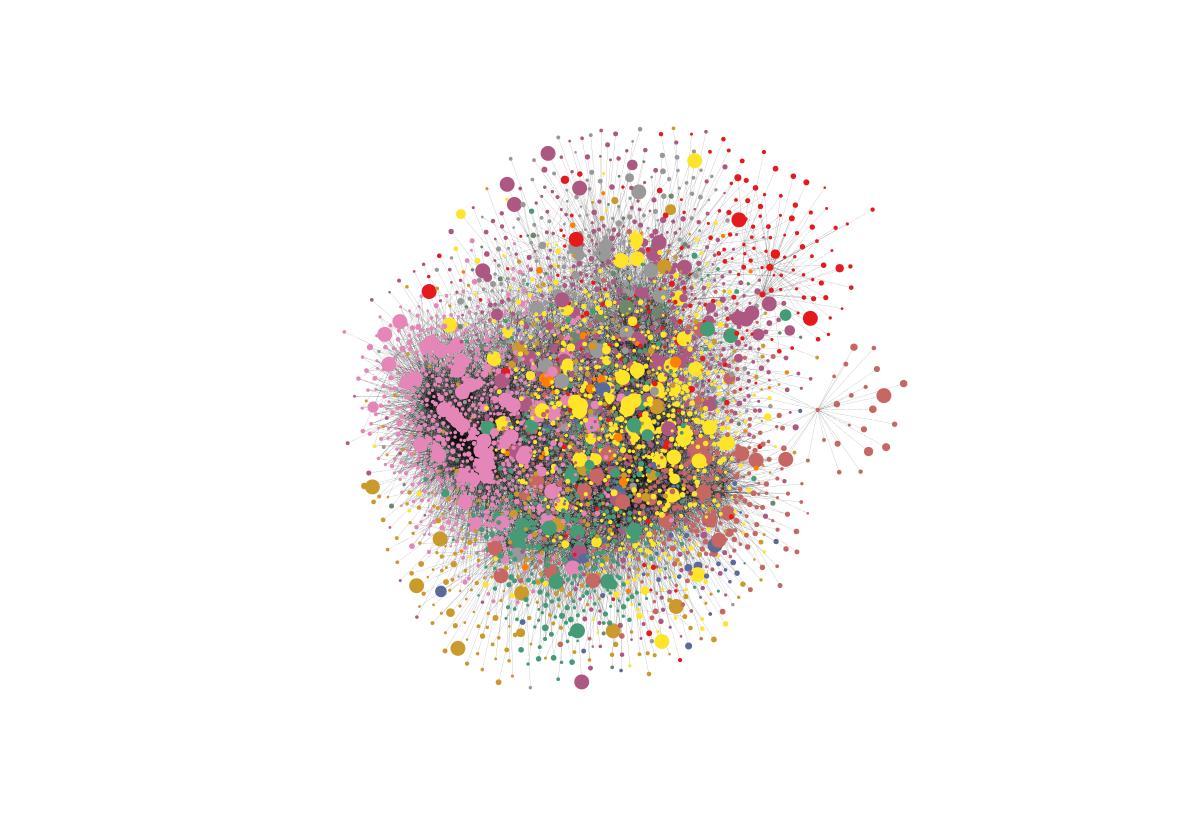

In [43]:
COL=V(subG2)$color
col2=rep(NA,length(V(subG2)))
col2[V(subG2)$is_TF]="black"
labs=V(subG2)$gene_name

pdf(paste(filepre,"connected_components.subnetworks.nolab.pdf",sep="."),width=15,height=15)
plot(subG2,layout=lay,vertex.frame.color=col2,vertex.label=NA,vertex.color=COL,edge.width=0.1,edge.color="black",edge.arrow.size=0)
dev.off()
pdf(paste(filepre,"connected_components.subnetworks.lab.pdf",sep="."),width=15,height=15)
plot(subG2,layout=lay,vertex.frame.color=col2,vertex.label=labs,vertex.label.cex=.7,vertex.color=COL,edge.width=0.1,edge.color="black",edge.arrow.size=0)
dev.off()
plot(subG2,layout=lay,vertex.frame.color=col2,vertex.label=NA,vertex.color=COL,edge.width=0.05,edge.color="black",edge.arrow.size=0)

png 
  2

Warning message in text.default(x, y, labels = labels, col = label.color, family = label.family, :
“conversion failure on 'MS2‐1' in 'mbcsToSbcs': dot substituted for <e2>”Warning message in text.default(x, y, labels = labels, col = label.color, family = label.family, :
“conversion failure on 'MS2‐1' in 'mbcsToSbcs': dot substituted for <80>”Warning message in text.default(x, y, labels = labels, col = label.color, family = label.family, :
“conversion failure on 'MS2‐1' in 'mbcsToSbcs': dot substituted for <90>”Warning message in text.default(x, y, labels = labels, col = label.color, family = label.family, :
“font metrics unknown for Unicode character U+2010”Warning message in text.default(x, y, labels = labels, col = label.color, family = label.family, :
“conversion failure on 'MS2‐1' in 'mbcsToSbcs': dot substituted for <e2>”Warning message in text.default(x, y, labels = labels, col = label.color, family = label.family, :
“conversion failure on 'MS2‐1' in 'mbcsToSbcs': dot substituted

png 
  2

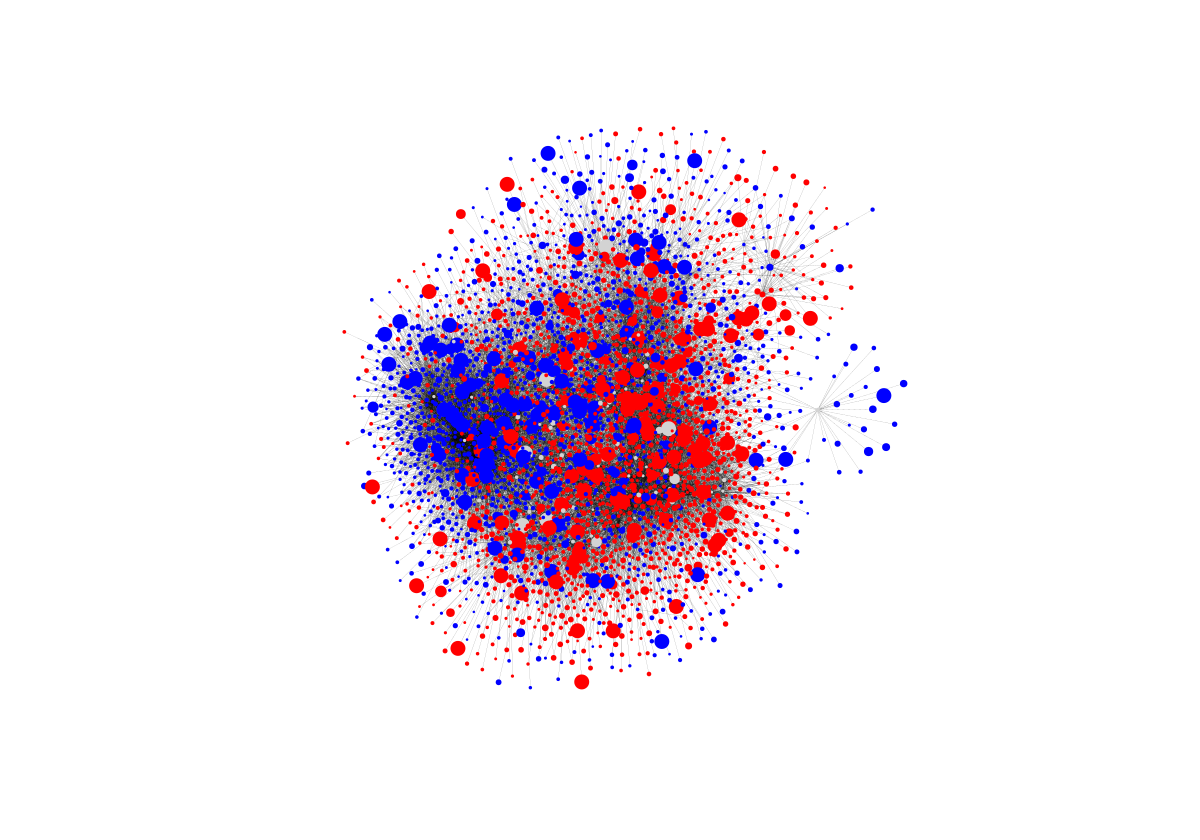

In [44]:
COL=ifelse(V(subG2)$direction=="unchanged", "lightgrey", ifelse(V(subG2)$direction=="up", "red","blue"))
col2=rep(NA,length(V(subG2)))
col2[V(subG2)$is_TF]="black"
labs=V(subG2)$gene_name
pdf(paste(filepre,"connected_components.direction.nolab.pdf",sep="."),width=15,height=15)
plot(subG2,layout=lay,vertex.frame.color=col2,vertex.label=NA,vertex.color=COL,edge.width=0.1,edge.color="black",edge.arrow.size=0)
dev.off()
pdf(paste(filepre,"connected_components.direction.lab.pdf",sep="."),width=15,height=15)
plot(subG2,layout=lay,vertex.frame.color=col2,vertex.label=labs,vertex.label.cex=.7,vertex.color=COL,edge.width=0.1,edge.color="black",edge.arrow.size=0)
dev.off()
plot(subG2,layout=lay,vertex.frame.color=col2,vertex.label=NA,vertex.color=COL,edge.width=0.05,edge.color="black",edge.arrow.size=0)

In [45]:
nrow(Q)
nrow(extendo)
write.table(Q,file=paste(filepre,"connected_components.tsv"),sep="\t",col.names=TRUE,row.names=FALSE,quote=FALSE)
write.table(extendo,file=paste(filepre,"all.tsv"),sep="\t",col.names=TRUE,row.names=FALSE,quote=FALSE)

[1] 3572

[1] 3808

In [46]:
options(warn=-1)
write_graph(subG,file=paste(filepre,"full_graph.xml",sep="."),format="graphml")
write_graph(subG2,file=paste(filepre,"connected_components_graph.xml",sep="."),format="graphml")
options(warn=0)